# Library imports

In [4]:
# For the explanaition part
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree

# For the llm part
from dotenv import load_dotenv
import requests
import os

ModuleNotFoundError: No module named 'shap'

### Data loading and cleaning

In [3]:
# load the data
data = pd.read_csv("../02_Myocardial_infarction_complications_Database.csv")

In [4]:
# remove the columns corresponding to other complications that we do not want to predict
data = data.drop('KFK_BLOOD', axis=1)
data = data.drop('IBS_NASL', axis=1)
data = data.drop('LET_IS', axis=1)
data = data.drop('P_IM_STEN', axis=1)
data = data.drop('REC_IM', axis=1)
data = data.drop('DRESSLER', axis=1)
data = data.drop('RAZRIV', axis=1)
data = data.drop('OTEK_LANC', axis=1)
data = data.drop('A_V_BLOK', axis=1)
data = data.drop('FIBR_JELUD', axis=1)
data = data.drop('JELUD_TAH', axis=1)
data = data.drop('PREDS_TAH', axis=1)
data = data.drop('FIBR_PREDS', axis=1)
data = data.drop('ID', axis=1)

data = data.fillna(0)

### Model training

Separate features and target variable

In [5]:
X = data.drop('ZSN', axis=1)
one_hot_X = pd.get_dummies(X)
y = data.ZSN

In [6]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, test_size=0.2)
model = XGBClassifier()
model.fit(X_train.values, y_train.values)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### LIME explainer

In the following cell we create the lime explainer, which helps us understand the motive behind model predictions, and we choose two specific case where the model is highly confident in predicting either outcome.

In [7]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns.values.tolist(),
    class_names=[0,1], verbose=True, 
    mode='classification'
)
#explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_train.columns.values.tolist(), class_names=['ZSN'], mode='classification', verbose=True)

# We set our confidence treshold at 80% 
j = 0
k = 0
thresh = 0.8

# We get the propability predictions for all test cases
preds = model.predict_proba(X_test)

# We find an example where the prediction is 1:
for i in range(42):
    if (preds[i])[0]>thresh: # If probability of class 0 is >80%
        j = i
    if (preds[i])[1]>thresh: # If probability of class 1 is >80%
        k = i

print("prediction for instance", j, "in test data:", model.predict_proba(X_test)[j])
print("prediction for instance", k, "in test data:", model.predict_proba(X_test)[k])

prediction for instance 41 in test data: [0.99043286 0.00956713]
prediction for instance 38 in test data: [0.09778076 0.90221924]


LIME works by adding the differents weights of the features to the intercept, generating the probaility of the positive class according to it, Prediction_local. It's similar to the "Right" value, which is the actual prediction of the model, showing that LIME has created a good local explanation.

In [8]:
# We generate a LIME explanation for the first chosen instance:
exp = explainer.explain_instance(X_test.values[j], model.predict_proba, num_features=6)

feature_weights = exp.as_list()  # This gets all feature-weight pairs

for feature, weight in feature_weights:
    print(f"Feature: {feature:<30} Weight: {weight:>10.4f}")

exp.show_in_notebook(show_table=True)

Intercept 0.5664150028244836
Prediction_local [0.10998821]
Right: 0.009567131
Feature: ZSN_A <= 0.00                  Weight:    -0.3277
Feature: NA_R_3_n <= 0.00               Weight:    -0.0959
Feature: zab_leg_01 <= 0.00             Weight:    -0.0755
Feature: 5.97 < L_BLOOD <= 7.85         Weight:     0.0543
Feature: ALT_BLOOD <= 0.15              Weight:    -0.0476
Feature: DLIT_AG <= 0.00                Weight:     0.0361


In the following explanation, LIME isn't able to capure well the model's behaviour, with a discrepancy between it's local prediction and the model's one.

In [9]:
# We generate a LIME explanation for the second chosen instance:
exp = explainer.explain_instance(X_test.values[k], model.predict_proba, num_features=6)

feature_weights = exp.as_list()  # This gets all feature-weight pairs
for feature, weight in feature_weights:
    print(f"Feature: {feature:<30} Weight: {weight:>10.4f}")
exp.show_in_notebook(show_table=True)

Intercept 0.2527573251422242
Prediction_local [0.38142766]
Right: 0.90221924
Feature: ZSN_A > 0.00                   Weight:     0.3272
Feature: zab_leg_01 <= 0.00             Weight:    -0.0966
Feature: NA_R_2_n <= 0.00               Weight:    -0.0642
Feature: 54.00 < AGE <= 63.00           Weight:    -0.0431
Feature: TRENT_S_n > 0.00               Weight:     0.0290
Feature: lat_im <= 0.00                 Weight:    -0.0237


### SHAP explainer

In this section we will analyze the predictions using the shapley values.

In [10]:
# We fit the explainer
explainer = shap.TreeExplainer(model)
# We calculate the SHAP values - may take some time
shap_values = explainer.shap_values(X_test)

The position on the x-axis shows the impact of each feature on the prediction, with negative being less likely to CHF, and the opposite with a positive value.

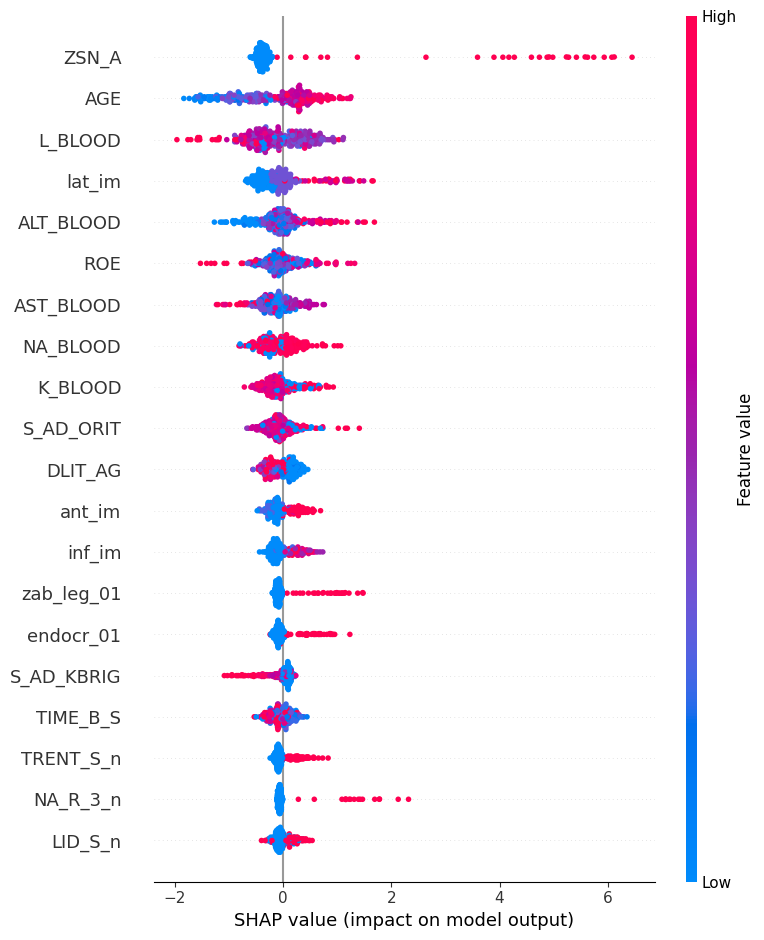

In [11]:
shap.summary_plot(shap_values, X_test)

In [12]:
# We select a feature, then create an individual conditional expectation plot 
# (using PDP plot, with kind = "individual")
features = [9]
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')

AttributeError: 'super' object has no attribute '__sklearn_tags__'

"ZSN_A" is coded in the original dataset on 4 values, from 0 to 4, each representing a stage of heart failure. Thus the plot is somewhat misleading.

The next plot could be considered more correct.

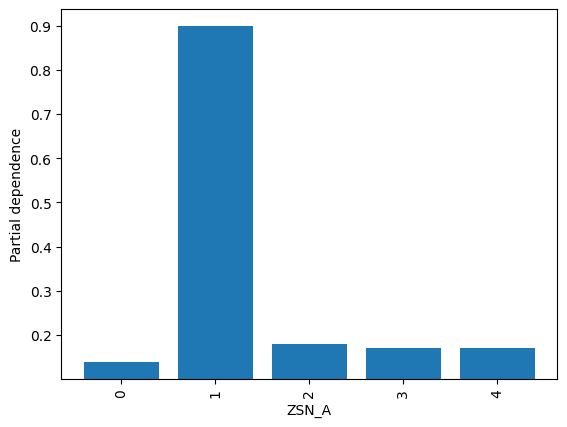

In [16]:
PartialDependenceDisplay.from_estimator(
    model, 
    X_test,
    features=[9],
    categorical_features=[9]
)


In the following plot we can see how each feature contributes to pushing the prediction from the base value (E[f(X)] = -1.334) to the final prediction.

In the first plot, we find ourserlves with a final negative value, meaning the model is quite confident this patient will not develop CHF as a complication, while in the second plot it's the opposite.

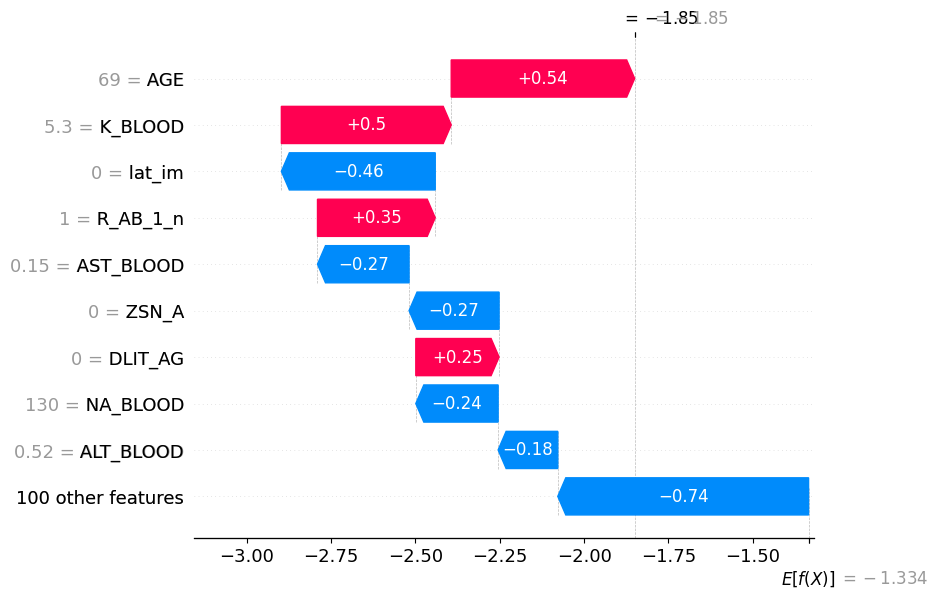

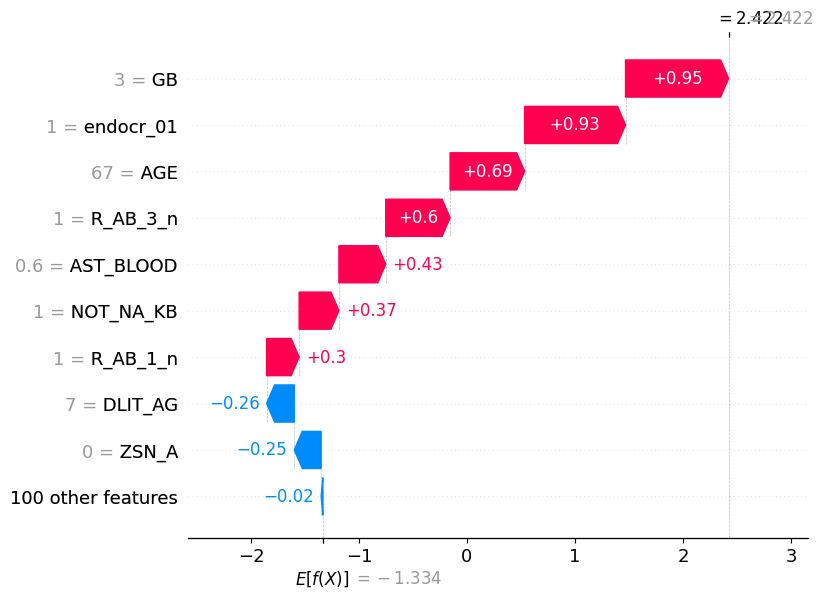

In [12]:
# let's produce SHAP waterfall plots for the two instances where the model is confident (see above):
expl = shap.TreeExplainer(model)
vals = expl(X_test)
shap.plots.waterfall(vals[j])
shap.plots.waterfall(vals[k])